# 이미지 기반 유사도


<체크해야할 사항>
1. 시중교재 문제와의 유사도
2. 중복문제 아이디

## 시중문제 준비 

In [1]:
file_path = './시중문제파일/'

In [2]:
file_name = '13529414.png'

In [3]:
import matplotlib.pyplot as plt

In [4]:
from PIL import Image

In [5]:
img = Image.open(file_path+file_name)

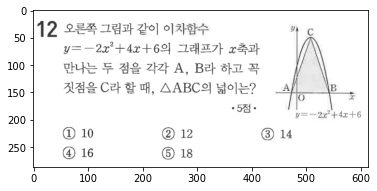

In [6]:
plt.imshow(img)
plt.show()

## 해당 문제의 unitCode, problemLevel 알아내기 

In [7]:
import pymysql
prob_db = pymysql.connect(
    user='real', 
    passwd='vmfl515!dnlf', 
    host='mathflat-dev-cluster.cluster-ce1us4oyptfa.ap-northeast-2.rds.amazonaws.com', 
    db='iclass', 
    charset='utf8'
)

In [8]:
curs = prob_db.cursor(pymysql.cursors.DictCursor) 

In [10]:
sql = "SELECT ID, BookNameCode, unitCode, problemLevel FROM iclass.Table_middle_book_data where BookNameCode = 2319611"

In [11]:
sql

'SELECT ID, BookNameCode, unitCode, problemLevel FROM iclass.Table_middle_book_data where BookNameCode = 2319611'

In [12]:
curs.execute(sql)

100

In [13]:
import pandas as pd

test_df = curs.fetchall()
test_df = pd.DataFrame(test_df)

In [14]:
test_df

,ID,BookNameCode,unitCode,problemLevel
0,13529329,2319611,231000006,2
1,13529328,2319611,231000009,1
2,13529330,2319611,231000024,2
3,13529346,2319611,231000027,2
4,13529331,2319611,231000039,2
...,...,...,...,...
95,13529414,2319611,231300542,2
96,13529418,2319611,231301006,4
97,13529419,2319611,231301009,3
98,13529420,2319611,231301012,3


In [15]:
test_df.set_index("ID",inplace=True)

In [16]:
idd = int(file_name.split('.')[0])
idd

13529414

In [17]:
unitcode = test_df.loc[idd,'unitCode']

In [18]:
unitcode

231300542

In [19]:
prolevel = test_df.loc[idd,'problemLevel']

In [20]:
prolevel

2

## 문제은행 문제 리스트 

In [21]:
#문제 난이도 고려 X
sql = "SELECT * FROM iclass.Table_middle_problems where unitCode =  "+str(unitcode) 
curs.execute(sql)

117

In [33]:
#문제 난이도 고려 O
sql = "SELECT * FROM iclass.Table_middle_problems where unitCode =  "+str(unitcode) + " and problemLevel = "+str(prolevel) 
curs.execute(sql)

58

In [34]:
result = curs.fetchall()

In [35]:
import pandas as pd

result = pd.DataFrame(result)
result.head()

,ID,unitCode,problemIDByUnit,problemLevel,problemType,problemURL,answerData,totalTimes,correctTimes,curriculumNumber,...,ClassID,NeedCheckLayout,DateTime_Add,DateTime_Update,Delimiter,PreviousConceptCode1,PreviousConceptCode2,PreviousConceptCode3,hwpExist,scorable
0,444973,231300542,10,2,객관식,/math_problems/Mo/MO_201103/h1/201103_Bu/10_,5,10278,7972,15,...,0,0,NaT,2020-07-14 21:45:57,0,0,0,0,1,1
1,445491,231300542,11,2,객관식,/math_problems/Mo/MO_201303/h1/201303_Bu/11_,4,10181,6897,15,...,0,0,NaT,2020-07-14 21:45:57,0,0,0,0,1,1
2,470382,231300542,17,2,주관식,/math_problems/9/m/3/1/128/9_231128_bcVPC_17_,35,902,546,15,...,0,0,2019-05-27,2020-07-14 21:33:58,0,0,0,0,1,1
3,470383,231300542,18,2,주관식,/math_problems/9/m/3/1/128/9_231128_bcVPC_18_,12,1033,584,15,...,0,0,2019-05-27,2020-07-14 16:47:52,0,0,0,0,1,1
4,470384,231300542,19,2,주관식,/math_problems/9/m/3/1/128/9_231128_bcVPC_19_,8,932,544,15,...,0,0,2019-05-27,2020-07-14 17:21:44,0,0,0,0,1,1


In [36]:
result.set_index("ID",inplace = True)

# 같은 유형 코드의 문제은행 문제들 벡터화

In [37]:
import requests
import os,io
from PIL import Image
from torchvision import transforms, models
import torch
from tqdm import tqdm, notebook

class Img2VecResnet18():
    def __init__(self):
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
    
# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
unavailable_ele = []
print("Converting images to feature vectors:")
for ID in notebook.tqdm(result.index):
#     try:
        I = Image.open(os.path.join("myimages", "test"+str(ID)+".jpg"))
        vec = img2vec.getVec(I)
        allVectors[ID] = vec
        I.close() 
#     except:
#         unavailable_ele.append(ID) #png파일이 없는 문제 ID
#         print(ID)
#         pass
        

Converting images to feature vectors:


# 시중문제 샘플 변환 & 벡터화

In [38]:
inputDim = (224,224)

img = img.convert('RGB')

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

newI = transformationForCNNInput(img)
    
# ResNet18 이용해서 feature vector로 변환
vec = img2vec.getVec(newI)

allVectors['sample'] = vec

In [39]:
allVectors.keys()

dict_keys([444973, 445491, 470382, 470383, 470384, 470385, 470386, 470387, 470390, 470391, 470392, 470393, 470394, 470395, 470397, 470398, 470399, 470400, 470402, 470404, 470405, 470406, 470407, 470408, 470410, 470416, 470417, 470418, 470419, 470420, 470425, 470435, 470436, 470438, 470439, 470440, 470441, 470442, 470443, 470444, 470445, 470446, 470447, 470448, 470449, 470450, 470463, 470464, 470465, 470466, 470467, 470468, 470469, 470470, 470471, 470479, 470480, 470483, 'sample'])

In [40]:
# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())

    matrix = pd.DataFrame(sim, columns = keys, index = keys)

    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [41]:
from numpy.testing import assert_almost_equal
import re
from tqdm import notebook
import time

k = 4 # 유사 이미지 3개 뽑으려면
n = k+5 # 최악의경우 8개 뽑아야함 (중복문제 추리기)

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

# similarNames = cudf.from_pandas(similarNames)
# similarValues = cudf.from_pandas(similarValues)

for j in notebook.tqdm(range(similarityMatrix.shape[0])):
    
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(n)
    i = 1
    while True:
        try:
            if kSimilar[kSimilar.index[i]] == kSimilar[kSimilar.index[i-1]]:
                del kSimilar[kSimilar.index[i]]
                i -= 1
            else:
                i += 1
        except: break
    
    kSimilar = kSimilar.head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

In [42]:
similarNames

,0,1,2,3
444973,444973,470417,470392,470400
445491,445491,470405,470392,470416
470382,470382,470464,470408,470394
470383,470383,470384,470419,470397
470384,470384,470387,470425,470383
470385,470385,470386,470435,470406
470386,470386,470385,470435,470406
470387,470387,470384,470419,470425
470390,470390,470391,470464,470404
470391,470391,470404,470446,470390


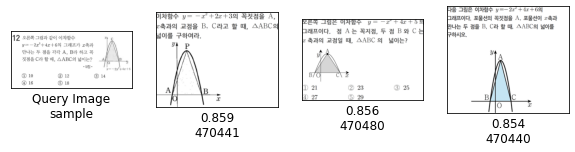

In [43]:
import matplotlib.pyplot as plt
    
# take three examples from the provided image set and plot
inputImages = ['sample']
inputDir = 'originalImages'
numCol = 4
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("{1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
#     print(simImages)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open('./시중문제파일/'+file_name)
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, 'test'+str(simImages[j-1])+'.png'))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)

444973


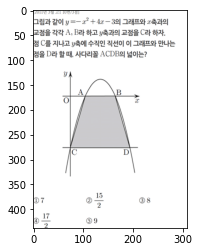

445491


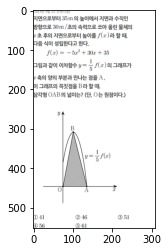

470382


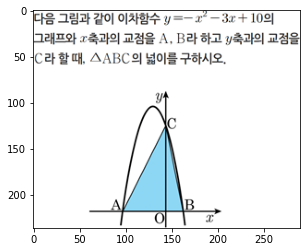

470383


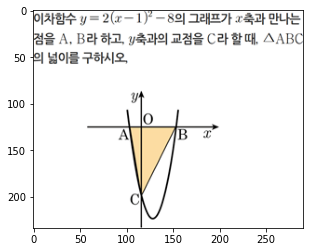

470384


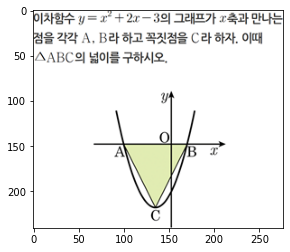

470385


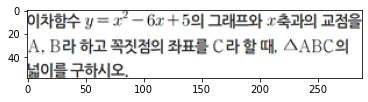

470386


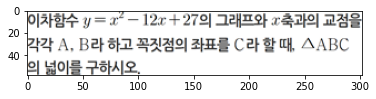

470387


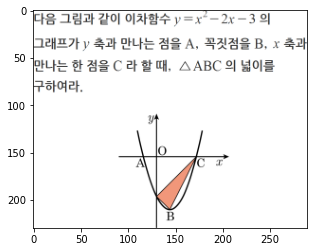

470390


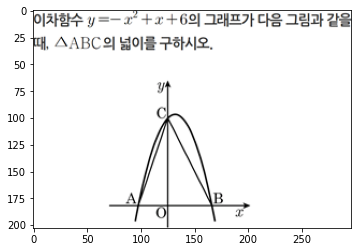

470391


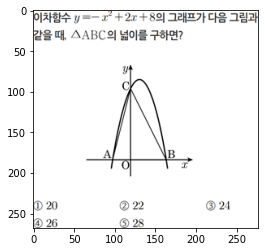

470392


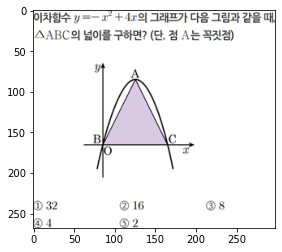

470393


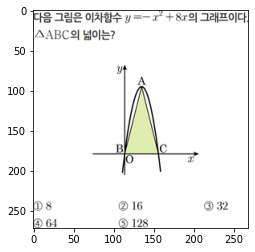

470394


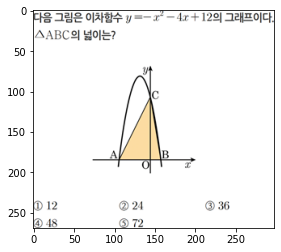

470395


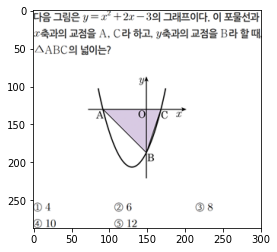

470397


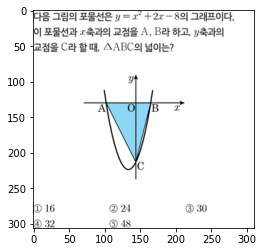

470398


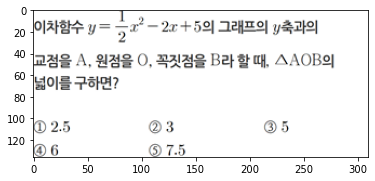

470399


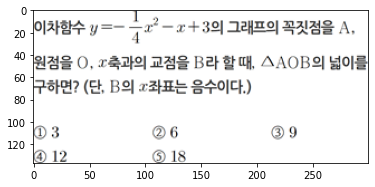

470400


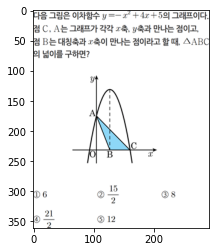

470402


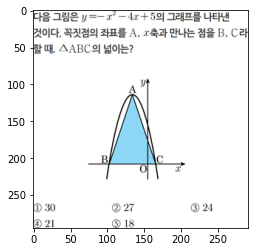

470404


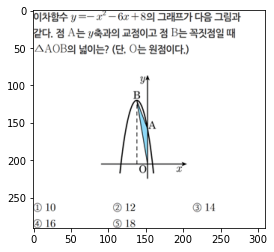

470405


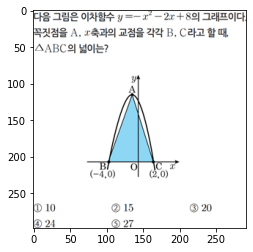

470406


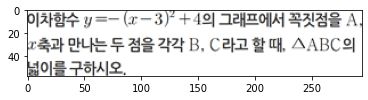

470407


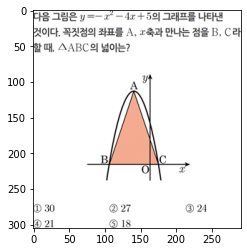

470408


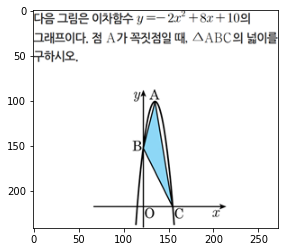

470410


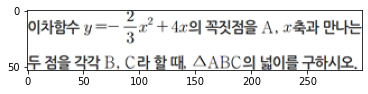

470416


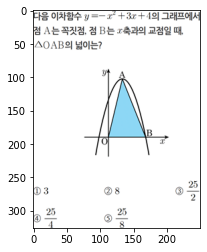

470417


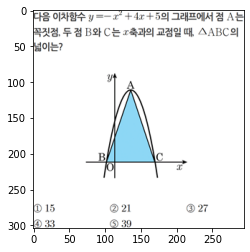

470418


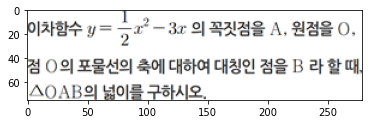

470419


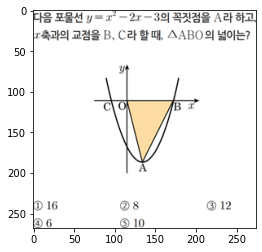

470420


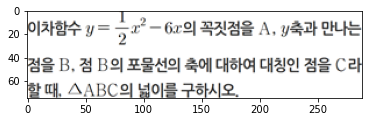

470425


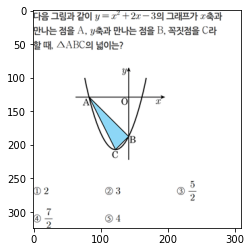

470435


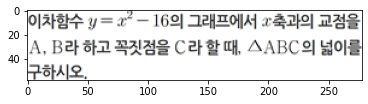

470436


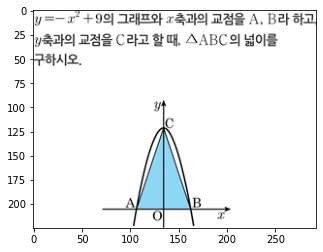

470438


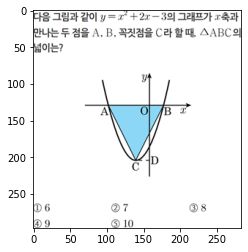

470439


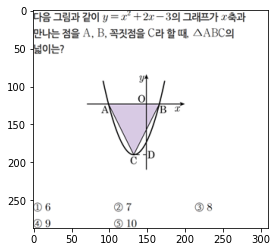

470440


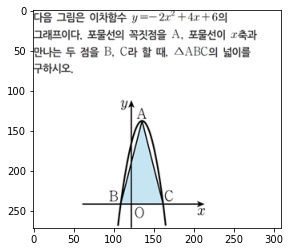

470441


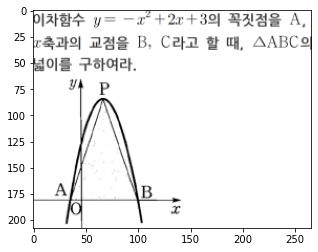

470442


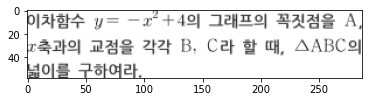

470443


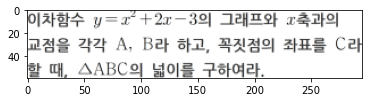

470444


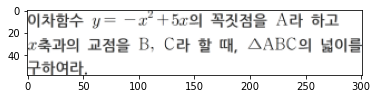

470445


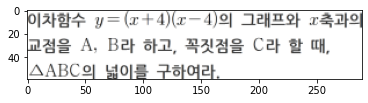

470446


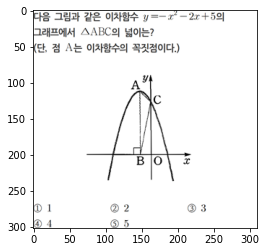

470447


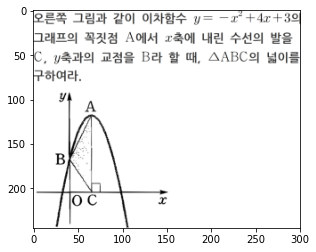

470448


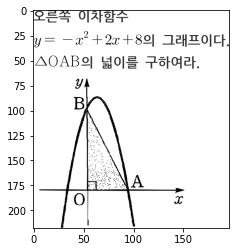

470449


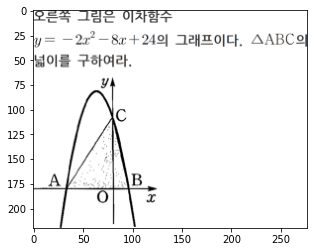

470450


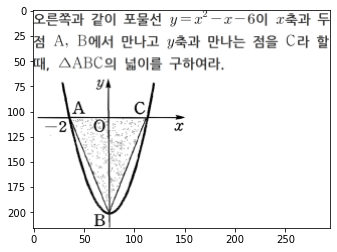

470463


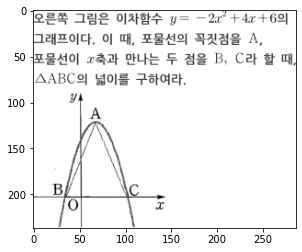

470464


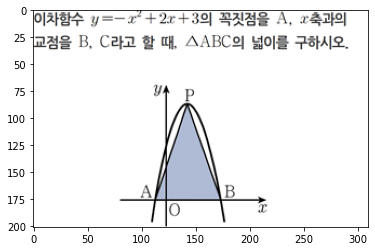

470465


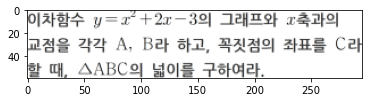

470466


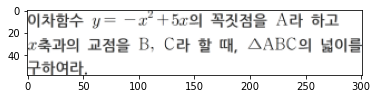

470467


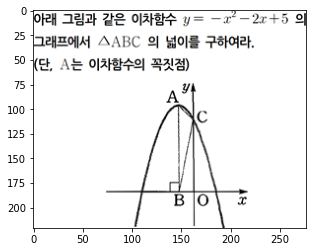

470468


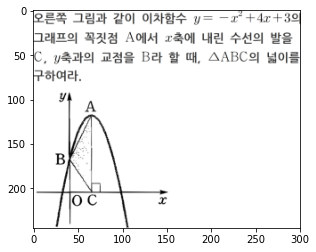

470469


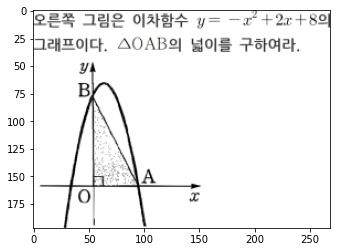

470470


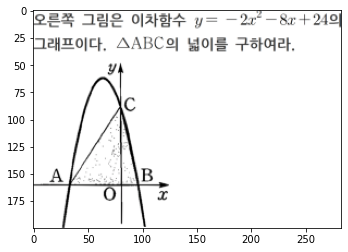

470471


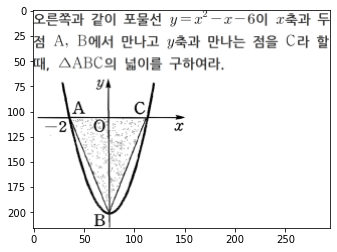

470479


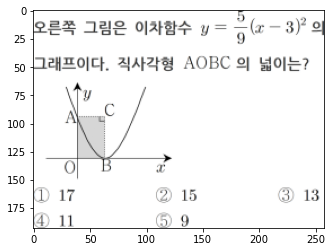

470480


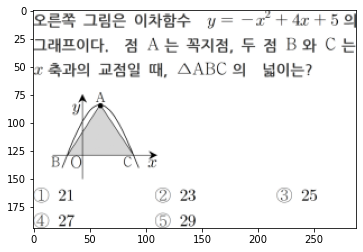

470483


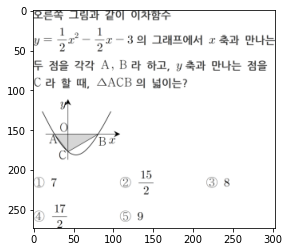

In [44]:
# f, axes = plt.subplot(10,5)
import matplotlib.pyplot as plt
import cv2

imglist = list(similarNames.index[:-1])

inputDir = 'originalImages'

for i in imglist:
    print(i)
    fname = './originalImages/test'+str(i)+'.png'
    im = plt.imread(fname)
    plt.imshow(im)
    plt.show()
    

In [ ]:
import cv2
fname = './originalImages/test437970.png'
im = cv2.imread(fname)
print(im)
cv2.imshow('437970',im)

In [64]:
print(im)

None
